<a href="https://colab.research.google.com/github/kavita1910/sequential_sentence_classification_in_medical_abstract/blob/main/sequential_sentence_classification_in_medical_abstract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequential sentence classification in medical abstract

**Aim** : Replicating the deep learning model behind the 2017 paper `PubMed 200k RCT: A Dataset for Sequenctial Sentence Classification in Medical Abstracts`.

**The goal of the dataset** was to explore the ability for NLP models to classify sentences which appear in sequential order.

In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

Example :
* inputs - (harder to read abstract from PubMed) and 
* outputs - (easier to read abstract) of the model we're going to build. 

The model will take an abstract wall of text and predict the section label each sentence should have.

**`Problem statement :`** 

> The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

**`Solution :`** 

Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature and dive deeper when necessary.

**`Steps to be followed :`**

* Downloading a text dataset (PubMed RCT200k from GitHub)
* Writing a preprocessing function to prepare our data for modelling
* Setting up a series of modelling experiments
* Making a baseline (TF-IDF classifier)
* Deep models with different combinations of: 
  * token embeddings, 
  * character embeddings, 
  * pretrained embeddings, 
  * positional embeddings
* Building our first multimodal model (taking multiple types of data inputs)
* Replicating the model architecture from https://arxiv.org/pdf/1612.05251.pdf
* Find the most wrong predictions
* Making predictions on PubMed abstracts from the wild

In [ ]:
# Confirm access to the GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-9fc8c384-1dd6-4a38-3dac-cba6fd0a09a1)


## Get Data
The authors of the paper have made the data they used for their research availably publically and for free in the form of .txt files on GitHub.

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


Rather than working with the whole 200k dataset, keep our experiments quick by starting with a smaller subset. 

In [ ]:
#Check what files are in PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


The dataset is already been split into : 
* train set - train.txt
* validattion set - dev.txt
* test set - test.txt

In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data
Write some code to read each of the lines in a target file.

In [ ]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args : 
    filename : a string containing the target filepath to read.
  
  Returns :
    A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Read in the training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

**`Observations :`**

- The role of each sentence is prefixed at the start of each line separated by a tab (\t) and each sentence finishes with a new line (\n).
- Different abstracts are separated by abstract ID's (lines beginning with ###) and newlines (\n).
- The number are replaced by '@'

## Clean data
* Take a target file of abstract samples.
* Read the lines in the target file.
* For each line in the target file:
  * If the line begins with `###` mark it as an `abstract ID` and the beginning of a new abstract.
    * Keep count of the number of lines in a sample.
  * If the line begins with `\n` mark it as the `end of an abstract sample`.
    * Keep count of the total lines in a sample.
  * Record the text before the \t as the label of the line.
  * Record the text after the \t as the text of the line.
* Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
  * "line_number" - the position of the line in the abstract (e.g. 3).
  * "target" - the role of the line in the abstract (e.g. OBJECTIVE).
  * "text" - the text of the line in the abstract.
  * "total_lines" - the total lines in an abstract sample (e.g. 14).
  * Abstract ID's and newlines should be omitted from the returned preprocessed data.

Example of returned preprocessed sample (a single line from an abstract):

```
[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'Emotional eating is associated with overeating and the development of obesity .\n',',
  'total_lines': 11},
...]
```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data 
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all the lines from a filename
  abstract_lines = ""               # create an empty abstract
  abstract_samples = []             # createa an empty list of abstracts
  
  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"):      # check to see if line is an ID line
      abstract_id = line
      abstract_lines = ""           # reset the abstract string if the line is an ID line

    elif line.isspace():            # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [ ]:
# Get data from the file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 541 ms, sys: 116 ms, total: 657 ms
Wall time: 661 ms


In [ ]:
# Check the first abstract of the training data 
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Turn the list into a DataFrame

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


## Data analysis

In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

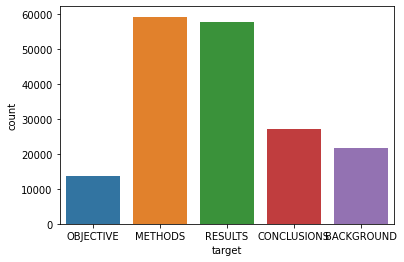

In [ ]:
import seaborn as sns
sns.countplot(x='target',data=train_df)

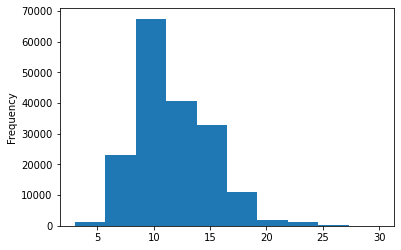

In [ ]:
train_df.total_lines.plot.hist();

Most of the abstracts are around 7 to 15 sentences in length.

## Get list of sentences
For a deep learning model, one of its main inputs will be a list of strings (the lines of an abstract).

In [ ]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:20]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)
Create one hot and label encoded labels.

We could just make label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels (this will enable us to use label smoothing later on).

### One-Hot Encoded Labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
train_labels_one_hot = ohe.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = ohe.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = ohe.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label Encoded labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a series of model experiments

Start by creating a simple baseline model to obtain a score and try to beat by building more and more complex models as moving towards replicating the sequence model outlined in Neural networks for joint sentence classification in medical paper abstracts.

For each model, train it on the training data and evaluate it on the validation data.


### Model 0: Getting a baseline
First model will be a **`TF-IDF Multinomial Naive Bayes`** as recommended by Scikit-Learn's machine learning map.

To build it, 
- create a Scikit-Learn Pipeline which uses 
  * the `TfidfVectorizer` class to convert our abstract sentences to numbers using the `TF-IDF (term frequency-inverse document frequecy) algorithm` and 
  * then learns to classify our sentences using the `MultinomialNB aglorithm`.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

# Fit the pipeline to training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
# Evaluate baseline model on validation data
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make prediction using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics  import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data for deep sequence models
Create vectorization and embedding layers.

The `vectorization layer` will convert our text to numbers. 

The `embedding layer` will capture the relationships between those numbers.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

For turning the sentences into numbers, it's a good idea to figure out how many words are in each sentence.

When model goes through the sentences, it works best when they're all the same length (this is important for creating batches of the same size tensors).

For example, if one sentence is eight words long and another is 29 words long, pad the eight word sentence with zeros so it ends up being the same length as the 29 word sentence.

In [ ]:
# How long is each sentence on average?
sentence_length = [len(sentence.split()) for sentence in train_sentences]
avg_sen_length = np.mean(sentence_length)
avg_sen_length  # return average sentence length (in tokens)

26.338269273494777

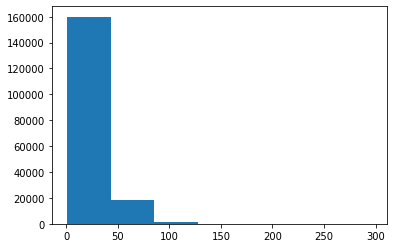

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sentence_length, bins=7);

Vast majority of sentences are between 0 and 50 tokens in length.

In [ ]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sentence_length, 95))
output_seq_len

55

95% of the sentences in training set has a length of 55 tokens or less.

When creating tokenization layer, use this value to turn all of our sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).

**Question:** Why 95%?

We could use the max sentence length of the sentences in the training set.

In [ ]:
# Maximum sentence length in the training set
max(sentence_length)

296

However, since hardly any sentences even come close to the max length, it would mean the majority of the data we pass to our model would be zeros (sinces all sentences below the max length would get padded with zeros).

## Create text vectorizer
Section 3.2 of the PubMed 200k RCT paper states that the vocabulary size of the PubMed 20k dataset as **68,000**. So use that as `max_tokens` parameter.

In [ ]:
# How many words are in our vocabulary?
max_tokens = 68000

And since discovered a sentence length of 55 covers 95% of the training sentences, use that as our output_sequence_length parameter.



In [ ]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                       output_sequence_length=55) # desired output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test text vectorizer
import random
target_sentences = random.choice(train_sentences)
print(f"Text:\n {target_sentences}")
print(f"\nLength of the text: {len(target_sentences.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentences])}")

Text:
 multivariable analyses were conducted to assess associations with nt-probnp levels .

Length of the text: 11

Vectorized text:
[[1478  291    9  198    6  216  992    7 2805   93    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}")
print(f"Most common words in a vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in a vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in a vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in a vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

## Create custom text embedding

`token_vectorization` layer maps the words in text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an **embedding**.

As the model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

The `input_dim` parameter defines the size of our vocabulary. 

The `output_dim` parameter defines the dimension of the embedding output.

The embedding layer will take the integer outputs of our text_vectorization layer as inputs and convert them to feature vectors of size output_dim.

In [ ]:
# Create token embedding layer 
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), # length of vocabulary
                               output_dim = 128,  # Note: different embedding sizes result in drastically different numbers of parameters to train
                               
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,          # If you have a lot of zeros, your neural networks, models can be computing and a lot of zero values.
                                                        # So the mass zero equals true helps Tenserflow to do more efficient computing when there's lots of zeros.
                               name="token_embedding")

# Show example embedding
print(f"Sentence before vectorization:\n {target_sentences}")
vectorized_sentence = text_vectorizer([target_sentences])
print(f"Sentence after vectorication (before embedding):\n {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}")
print(f"Embedded sentence shape: {embedded_sentence.shape}") 

Sentence before vectorization:
 multivariable analyses were conducted to assess associations with nt-probnp levels .
Sentence after vectorication (before embedding):
 [[1478  291    9  198    6  216  992    7 2805   93    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
Sentence after embedding:
 [[[ 0.00523617 -0.02394648 -0.0112113  ...  0.0392299  -0.00240266
   -0.00104064]
  [ 0.02691457 -0.01971878 -0.04549397 ... -0.00880434 -0.03067099
   -0.03402746]
  [-0.0099013   0.02094019  0.04652275 ... -0.04521836  0.01609943
   -0.00910995]
  ...
  [ 0.00701129 -0.04052003 -0.0380001  ...  0.03692437 -0.01662853
    0.04888434]
  [ 0.00701129 -0.04052003 -0.0380001  ...  0.03692437 -0.01662853
    0.04888434]
  [ 0.00701129 -0.04052003 -0.0380001  ...  0.03692437 -0.01662853
    0.04888434]]]
Embedded senten

## Create datasets
The tf.data API will ensure that tensorflow will process data as fast as possible.

The main steps we'll want to use with data is to turn it into a `PrefetchDataset` of batches.

Doing so will ensure TensorFlow loads data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched `PrefetchDataset` use the methods `batch()` and `prefetch()`, the parameter `tf.data.AUTOTUNE` will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 1: Conv1D with token embeddings

All of our deep models will follow a similar structure:

`Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)`

The first model to build is a 1-dimensional Convolutional Neural Network.

Standard machine learning workflow :

* Build model
* Train model
* Evaluate model (make predictions and compare to ground truth)

In [ ]:
# Create 1D Convvolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)  # vectorize text inputs
token_embedding = token_embed(text_vectors) # create embedding
x= layers.Conv1D(64, 
                 kernel_size=5, 
                 padding="same",
                 activation="relu")(token_embedding)
x = layers.GlobalAveragePooling1D()(x)  # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

Notice that majority of the trainable parameters are within the embedding layer. If we were to increase the size of the embedding (by increasing the output_dim parameter of the Embedding layer), the number of trainable parameters would increase dramatically.

In [ ]:
len(train_dataset)

5627

In [ ]:
5627*32

180064

Since training data contains nearly 200,000 sentences, fitting a deep model may take a while even with a GPU. So to keep experiments swift, run them on a subset of the training dataset.

More specifically, only use the first 10% of batches (about 18,000 samples) of the training set to train on and the first 10% of batches from the validation set to validate on.

> **Note:** It's a standard practice in machine learning to test your models on smaller subsets of data first to make sure they work before scaling them to larger amounts of data. Aim to run many smaller experiments rather than only a handful of large experiments. And since time is limited, one of the best ways to run smaller experiments is to reduce the amount of data working with (10% of the full dataset is usually a good amount, as long as it covers a similar distribution).

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),  # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps= int(0.1 * len(valid_dataset)))  #  only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 39s 13ms/step - loss: 0.9166 - accuracy: 0.6383 - val_loss: 0.6818 - val_accuracy: 0.7443
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6532 - accuracy: 0.7582 - val_loss: 0.6296 - val_accuracy: 0.7733
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6137 - accuracy: 0.7764 - val_loss: 0.5924 - val_accuracy: 0.7882


In [ ]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5944 - accuracy: 0.7880


[0.5944203734397888, 0.7879981398582458]

In [ ]:
# Make prediction
model_1_preds_probs = model_1.predict(valid_dataset)
model_1_preds_probs

array([[4.42840874e-01, 1.52539104e-01, 6.51347414e-02, 3.09690028e-01,
        2.97951568e-02],
       [4.19224352e-01, 2.98546553e-01, 1.43631855e-02, 2.57073998e-01,
        1.07918866e-02],
       [1.64705306e-01, 4.23239358e-03, 2.13323254e-03, 8.28874707e-01,
        5.44243849e-05],
       ...,
       [7.39723509e-06, 6.67170447e-04, 7.07863423e-04, 3.98042584e-06,
        9.98613596e-01],
       [5.20857014e-02, 4.80645835e-01, 7.85292611e-02, 6.26811758e-02,
        3.26058000e-01],
       [1.70589745e-01, 6.88080966e-01, 5.20474650e-02, 5.25821522e-02,
        3.66996899e-02]], dtype=float32)

In [ ]:
model_1_preds = tf.argmax(model_1_preds_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.79981464318814,
 'f1': 0.7855685173442839,
 'precision': 0.7850493526967443,
 'recall': 0.7879981464318814}

In [ ]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 72.18, New accuracy: 78.80, Difference: 6.62
Baseline precision: 0.72, New precision: 0.79, Difference: 0.07
Baseline recall: 0.72, New recall: 0.79, Difference: 0.07
Baseline f1: 0.70, New f1: 0.79, Difference: 0.09


### Model 2: Feature extraction with pretrained token embeddings

Moving towards replicating the model architecture in `Neural Networks for Joint Sentence Classification` in Medical Paper Abstracts, it mentions they used a `pretrained GloVe embedding` as a way to initialise their token embeddings.

To emulate this, let's see what results we can get with the `pretrained Universal Sentence Encoder embeddings` from TensorFlow Hub.

**Note:** We could use GloVe embeddings as per the paper but since we're working with TensorFlow, we'll use what's available from TensorFlow Hub (GloVe embeddings aren't). We'll save using pretrained GloVe embeddings as an extension.

The model structure will look like:

```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
```
You'll notice the lack of tokenization layer we've used in a previous model. This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.

This type of model is called transfer learning, or more specifically, `feature extraction transfer learning`. In other words, taking the patterns a model has learned elsewhere and applying it to our own problem.

We'll keep the pretrained embeddings frozen (by setting trainable=False) and add a trainable couple of layers on the top to tailor the model outputs to our own data.



In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]} (truncated_output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
the k-flap group showed significantly higher pain on their first postoperative day and significantly less pain after @ wk ( p < @ ) .
Sentence after embedding:
 [-0.03449764 -0.03657764  0.01677686 -0.00733715 -0.00020838  0.02670205
 -0.00153102 -0.05594925 -0.01113992  0.03747138  0.06393749 -0.02337455
 -0.01480262 -0.0649652   0.03464627  0.03401913 -0.02650589  0.05000326
  0.06948823  0.0168153  -0.01895227  0.07904129 -0.02432485 -0.01303657
  0.04593822  0.03485202 -0.07422627 -0.03901492 -0.04062563 -0.05364659] (truncated_output)...

Length of sentence embedding:
512


#### Building and fitting an NLP feature extraction model from TensorFlow Hub 

In [ ]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)  # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding)  # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


Checking the summary of model we can see there's a large number of total parameters, however, the majority of these are non-trainable. This is because we set `training=False` when we instatiated our USE feature extractor layer.

So when we train our model, only the top two output layers will be trained.

In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch= int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data = valid_dataset,
                              validation_steps= int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 20ms/step - loss: 0.9235 - accuracy: 0.6480 - val_loss: 0.7956 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 11s 20ms/step - loss: 0.7699 - accuracy: 0.7012 - val_loss: 0.7551 - val_accuracy: 0.7061
Epoch 3/3
562/562 [==============================] - 11s 20ms/step - loss: 0.7540 - accuracy: 0.7111 - val_loss: 0.7400 - val_accuracy: 0.7111


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.7426 - accuracy: 0.7123


[0.7425547242164612, 0.7122997641563416]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.40768123, 0.38488254, 0.00283218, 0.19763511, 0.00696891],
       [0.3433595 , 0.51099485, 0.00433851, 0.1392834 , 0.00202372],
       [0.2641922 , 0.16331182, 0.02386879, 0.5072138 , 0.0414134 ],
       ...,
       [0.00217952, 0.00586621, 0.05557659, 0.00097806, 0.93539965],
       [0.00475013, 0.04427149, 0.1878845 , 0.0013763 , 0.76171756],
       [0.17619069, 0.25009528, 0.50555587, 0.00564829, 0.06250986]],
      dtype=float32)

In [ ]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.22997484443268,
 'f1': 0.7094940648187826,
 'precision': 0.7125605265880295,
 'recall': 0.7122997484443268}

In [ ]:
compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_2_results)

Baseline accuracy: 72.18, New accuracy: 71.23, Difference: -0.95
Baseline precision: 0.72, New precision: 0.71, Difference: -0.01
Baseline recall: 0.72, New recall: 0.71, Difference: -0.01
Baseline f1: 0.70, New f1: 0.71, Difference: 0.01


### Model 3: Conv1D with character embeddings
#### Creating a character-level tokenizer

The Neural Networks for Joint Sentence Classification in Medical Paper Abstracts paper mentions their model uses a hybrid of token and character embeddings.

We've built models with a custom token embedding and a pretrained token embedding

The difference between a character and token embedding is that the character embedding is created using sequences split into characters (e.g. hello -> [h, e, l, l, o]) where as a token embedding is created on sequences split into tokens.

**Token level embeddings split sequences into tokens (words) and embeddings each of them, character embeddings split sequences into characters and creates a feature vector for each.**

In [ ]:
list(train_sentences[0])

['t',
 'o',
 ' ',
 'i',
 'n',
 'v',
 'e',
 's',
 't',
 'i',
 'g',
 'a',
 't',
 'e',
 ' ',
 't',
 'h',
 'e',
 ' ',
 'e',
 'f',
 'f',
 'i',
 'c',
 'a',
 'c',
 'y',
 ' ',
 'o',
 'f',
 ' ',
 '@',
 ' ',
 'w',
 'e',
 'e',
 'k',
 's',
 ' ',
 'o',
 'f',
 ' ',
 'd',
 'a',
 'i',
 'l',
 'y',
 ' ',
 'l',
 'o',
 'w',
 '-',
 'd',
 'o',
 's',
 'e',
 ' ',
 'o',
 'r',
 'a',
 'l',
 ' ',
 'p',
 'r',
 'e',
 'd',
 'n',
 'i',
 's',
 'o',
 'l',
 'o',
 'n',
 'e',
 ' ',
 'i',
 'n',
 ' ',
 'i',
 'm',
 'p',
 'r',
 'o',
 'v',
 'i',
 'n',
 'g',
 ' ',
 'p',
 'a',
 'i',
 'n',
 ' ',
 ',',
 ' ',
 'm',
 'o',
 'b',
 'i',
 'l',
 'i',
 't',
 'y',
 ' ',
 ',',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 's',
 'y',
 's',
 't',
 'e',
 'm',
 'i',
 'c',
 ' ',
 'l',
 'o',
 'w',
 '-',
 'g',
 'r',
 'a',
 'd',
 'e',
 ' ',
 'i',
 'n',
 'f',
 'l',
 'a',
 'm',
 'm',
 'a',
 't',
 'i',
 'o',
 'n',
 ' ',
 'i',
 'n',
 ' ',
 't',
 'h',
 'e',
 ' ',
 's',
 'h',
 'o',
 'r',
 't',
 ' ',
 't',
 'e',
 'r',
 'm',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 'w',
 'h',
 'e'

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

't h e   k - f l a p   g r o u p   s h o w e d   s i g n i f i c a n t l y   h i g h e r   p a i n   o n   t h e i r   f i r s t   p o s t o p e r a t i v e   d a y   a n d   s i g n i f i c a n t l y   l e s s   p a i n   a f t e r   @   w k   (   p   <   @   )   .'

In [ ]:
random_training_sentence

'the k-flap group showed significantly higher pain on their first postoperative day and significantly less pain after @ wk ( p < @ ) .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


To figure out how long our vectorized character sequences should be, let's check the distribution of our character sequence lengths.



In [ ]:
# What's the average character length
char_length = [len(sentence) for sentence in train_sentences]
mean_char_length = np.mean(char_length)
mean_char_length

149.3662574983337

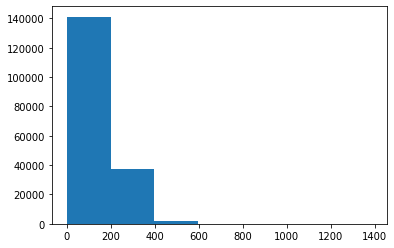

In [ ]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_length, bins=7);

most of our sequences are between 0 and 200 characters long.

Let's use NumPy's percentile to figure out what length covers 95% of our sequences.

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_length, 95))
output_seq_char_len

290

The sequence length which covers 95% of sequences, we'll use that in our TextVectorization layer as the output_sequence_length parameter.

Set `max_tokens` (the total number of different characters in our sequences) to 28, in other words, `26 letters of the alphabet + space + OOV (out of vocabulary or unknown)` tokens.

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize = "lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different charactersin char_vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different charactersin char_vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


test it on random sequences of characters to make sure it's working.

In [ ]:
# Test out character vectorizer
random_train_char = random.choice(train_chars)
print(f"Charified Text: \n {random_train_char}")
print(f"\n Length of chars: \n{len(random_train_char.split())}")
vectorized_chars = char_vectorizer([random_train_char])
print(f"\nVectorized chars: \n {vectorized_chars}") 
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified Text: 
 t h e   m e a n   a g e   i n   g r o u p - a   w a s   ,   @   +   /   -   @   y e a r s   w h e r e a s   i t   w a s   @   +   /   -   @   y e a r s   i n   g r o u p - b   .

 Length of chars: 
65

Vectorized chars: 
 [[ 3 13  2 15  2  5  6  5 18  2  4  6 18  8  7 16 14  5 20  5  9 19  2  5
   8  9 20 13  2  8  2  5  9  4  3 20  5  9 19  2  5  8  9  4  6 18  8  7
  16 14 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0 

Sequences with a length shorter than 290 (output_seq_char_length) get padded with zeros on the end, this ensures all sequences passed to our model are the same length.

Also, due to the standardize parameter of TextVectorization being "lower_and_strip_punctuation" and the split parameter being "whitespace" by default, symbols (such as @) and spaces are removed.

#### Creating a character-level embedding

The input dimension `(input_dim)` will be equal to the number of different characters in our `char_vocab (28)`. And since we're following the structure of the model in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, the output dimension of the character embedding `output_dim)` will be 25.

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,  # number of different characters
                              output_dim=25,  # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False,  # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n {random_train_char}\n")
char_embed_example = char_embed(char_vectorizer([random_train_char]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}")
print(f"Char embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
 t h e   m e a n   a g e   i n   g r o u p - a   w a s   ,   @   +   /   -   @   y e a r s   w h e r e a s   i t   w a s   @   +   /   -   @   y e a r s   i n   g r o u p - b   .

Embedded chars (after vectorization and embedding):
 [[[-0.03303299 -0.01447834 -0.04159562 ... -0.04636761  0.0368382
    0.01739509]
  [ 0.0495352  -0.01389759  0.04920274 ...  0.02595958 -0.00638511
    0.00496114]
  [-0.03677623 -0.00711075 -0.03183551 ...  0.04564697  0.03858704
    0.02906528]
  ...
  [ 0.00160257  0.02073909 -0.04916454 ...  0.0064547   0.04736741
   -0.0141188 ]
  [ 0.00160257  0.02073909 -0.04916454 ...  0.0064547   0.04736741
   -0.0141188 ]
  [ 0.00160257  0.02073909 -0.04916454 ...  0.0064547   0.04736741
   -0.0141188 ]]]
Char embedding shape: (1, 290, 25)


#### Building a Conv1D model to fit on character embeddings

The model will have the same structure as our custom token embedding model (model_1) except it'll take character-level sequences as input instead of token-level sequences.

`Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)`

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes,
                       activation="softmax")(x)
model_3 = tf.keras.Model(inputs,
                          outputs,
                          name="model_3_conv1D_char_embedding")

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           1750      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 10,139
Trainable params: 10,139
Non-trainable params: 0
_________________________________

Before fitting our model on the data, we'll create char-level batched PrefetchedDataset's to load data as fast as possible

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 10ms/step - loss: 1.2525 - accuracy: 0.4940 - val_loss: 1.0347 - val_accuracy: 0.5921
Epoch 2/3
562/562 [==============================] - 5s 10ms/step - loss: 1.0015 - accuracy: 0.5981 - val_loss: 0.9503 - val_accuracy: 0.6247
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.9277 - accuracy: 0.6356 - val_loss: 0.8758 - val_accuracy: 0.6612


In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.8901 - accuracy: 0.6558


[0.8901253938674927, 0.6557658910751343]

In [ ]:
model_3_preds_probs = model_3.predict(val_char_dataset)
model_3_preds_probs

array([[0.11712137, 0.5141307 , 0.08015158, 0.18880165, 0.09979465],
       [0.11378323, 0.5610553 , 0.01675953, 0.15325256, 0.1551494 ],
       [0.07354087, 0.32244322, 0.21156487, 0.23532791, 0.15712321],
       ...,
       [0.01299618, 0.03212528, 0.08037491, 0.0110472 , 0.8634564 ],
       [0.03502236, 0.0486081 , 0.4230901 , 0.00896366, 0.48431572],
       [0.3048317 , 0.59308815, 0.03353019, 0.05561231, 0.01293759]],
      dtype=float32)

In [ ]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_preds_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 1])>

In [ ]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.57659208261619,
 'f1': 0.6488142421551647,
 'precision': 0.6546624141390169,
 'recall': 0.6557659208261618}

In [ ]:
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 72.18, New accuracy: 65.58, Difference: -6.61
Baseline precision: 0.72, New precision: 0.65, Difference: -0.06
Baseline recall: 0.72, New recall: 0.66, Difference: -0.07
Baseline f1: 0.70, New f1: 0.65, Difference: -0.05


### Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:

1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Combine (using layers.Concatenate) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

So this is one of the main differences between the sequential API and the functional API, where the sequential API wants to go through a list of steps straightforward, the functional API can be used to combine multiple different steps as we're about to see here.

In [ ]:
# 1. Setup tokens inouts/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype = tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)   # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_concat")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

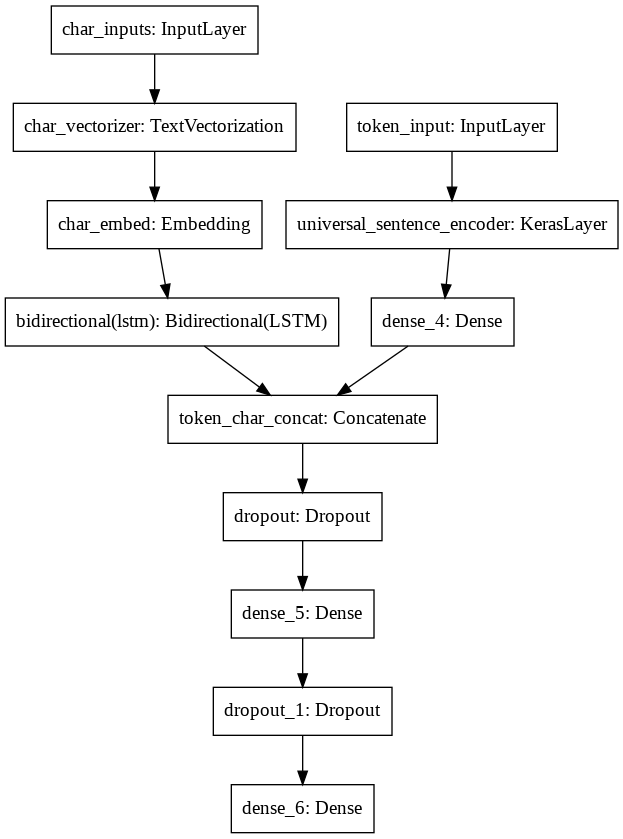

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

#### Combining token and character data into a tf.data dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)  # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train dataset
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeate same steps for validation set
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

#### Fitting a model on token and character-level sequences

In [ ]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 73s 122ms/step - loss: 0.9717 - accuracy: 0.6133 - val_loss: 0.7739 - val_accuracy: 0.7005
Epoch 2/3
562/562 [==============================] - 67s 120ms/step - loss: 0.7899 - accuracy: 0.6940 - val_loss: 0.7112 - val_accuracy: 0.7271
Epoch 3/3
562/562 [==============================] - 67s 120ms/step - loss: 0.7706 - accuracy: 0.7074 - val_loss: 0.6887 - val_accuracy: 0.7327


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 51s 54ms/step - loss: 0.6925 - accuracy: 0.7353


[0.6925491690635681, 0.73533695936203]

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.1570976e-01, 3.9484081e-01, 3.1713415e-03, 1.7556790e-01,
        1.0710120e-02],
       [3.7660214e-01, 3.9082065e-01, 5.1262830e-03, 2.2480874e-01,
        2.6422390e-03],
       [2.8515589e-01, 1.6754329e-01, 3.2473419e-02, 4.8083284e-01,
        3.3994481e-02],
       ...,
       [2.0132758e-04, 3.1956218e-03, 4.1745495e-02, 1.0117663e-04,
        9.5475638e-01],
       [4.7195158e-03, 5.4630540e-02, 1.9568707e-01, 2.8858406e-03,
        7.4207705e-01],
       [3.3640599e-01, 4.3631124e-01, 1.6021140e-01, 4.1695897e-02,
        2.5375521e-02]], dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.53369522044221,
 'f1': 0.7329692694293627,
 'precision': 0.7352821539941629,
 'recall': 0.7353369522044221}

In [ ]:
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 72.18, New accuracy: 73.53, Difference: 1.35
Baseline precision: 0.72, New precision: 0.74, Difference: 0.02
Baseline recall: 0.72, New recall: 0.74, Difference: 0.01
Baseline f1: 0.70, New f1: 0.73, Difference: 0.03


### Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

The process of applying your own knowledge to build features as input to a model is called **`feature engineering`**.

Since abstracts typically have a sequential order about them (for example, background, objective, methods, results, conclusion), it makes sense to add the line number of where a particular sentence occurs to our model. The beautiful thing is, these features will be available at test time (we can just count the number of sentences in an abstract and the number of each one).

Meaning, if we were to predict the labels of sequences in an abstract our model had never seen, we could count the number of lines and the track the position of each individual line and pass it to our model.

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


#### Create positional embeddings

Since our `"line_number"` and `"total_line"` columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with "line_number"=5 is five times greater than a line with `"line_number"=1`, we'll use one-hot-encoding to encode our `"line_number"` and `"total_lines"` features.

To do this, we can use the `tf.one_hot` utility.

`tf.one_hot` returns a one-hot-encoded tensor. It accepts an array (or tensor) as input and the depth parameter determines the dimension of the returned tensor.

To figure out what we should set the depth parameter to, let's investigate the distribution of the `"line_number"` column.

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

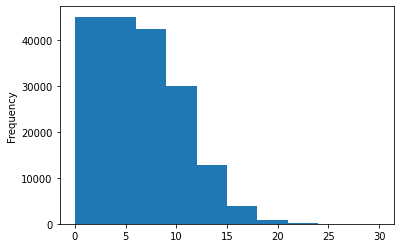

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

majority of lines have a position of 15 or less.

Knowing this, let's set the depth parameter of tf.one_hot to 15.

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

Setting the depth parameter of tf.one_hot to 15 means any sample with a "line_number" value of over 15 gets set to a tensor of all 0's, where as any sample with a "line_number" of under 15 gets turned into a tensor of all 0's but with a 1 at the index equal to the "line_number" value.

**Note:** We could create a one-hot tensor which has room for all of the potential values of "line_number" (depth=30), however, this would end up in a tensor of double the size of our current one (depth=15) where the vast majority of values are 0. Plus, only ~2,000/180,000 samples have a "line_number" value of over 15. So we would not be gaining much information about our data for doubling our feature space. This kind of problem is called the curse of dimensionality. However, since this we're working with deep models, it might be worth trying to throw as much information at the model as possible and seeing what happens. I'll leave exploring values of the depth parameter as an extension.

In [ ]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

We can do the same as we've done for our "line_number" column witht he "total_lines" column. First, let's find an appropriate value for the depth parameter of tf.one_hot.

In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

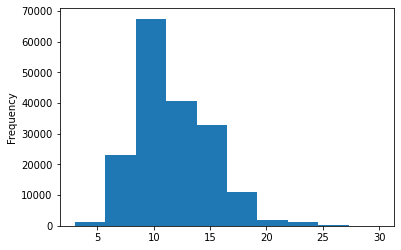

In [ ]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

a value of 20 looks like it covers the majority of samples.

We can confirm this with np.percentile().

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

#### Building a tribrid embedding model 
1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
4. Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
5. Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
6. Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_embeddings)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [ ]:
model_5.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_embed (Embedding)          (None, 290, 25)      1750        char_vectorizer[4][0]            
___________________________________________________________________________________________

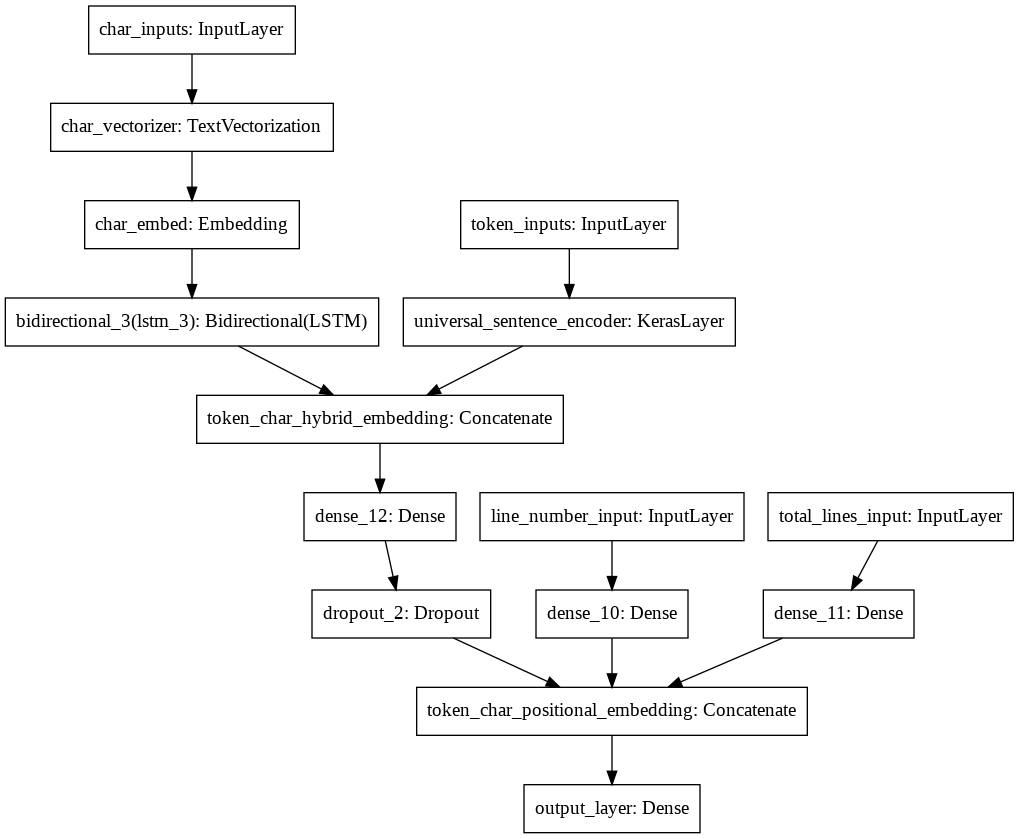

In [ ]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

Essentially what we're doing is trying to encode as much information about our sequences as possible into various embeddings (the inputs to our model) so our model has the best chance to figure out what label belongs to a sequence (the outputs of our model).

You'll notice our model is looking very similar to the model shown in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts. However, a few differences still remain:

* We're using pretrained TensorFlow Hub token embeddings instead of GloVe emebddings.
* We're using a Dense layer on top of our token-character hybrid embeddings instead of a bi-LSTM layer.
* Section 3.1.3 of the paper mentions a label sequence optimization layer (which helps to make sure sequence labels come out in a respectable order) but it isn't shown in Figure 1. To makeup for the lack of this layer in our model, we've created the positional embeddings layers.
* Section 4.2 of the paper mentions the token and character embeddings are updated during training, our pretrained TensorFlow Hub embeddings remain frozen.
* The paper uses the SGD optimizer, we're going to stick with Adam.

All of the differences above are potential extensions of this project.

In [ ]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f86fab32050> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f870ceb1e50> True
<keras.engine.input_layer.InputLayer object at 0x7f86faba99d0> True
<keras.layers.embeddings.Embedding object at 0x7f870ce21fd0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f8714c09fd0> False
<keras.layers.wrappers.Bidirectional object at 0x7f86fa95c6d0> True
<keras.layers.merge.Concatenate object at 0x7f86fa875a90> True
<keras.engine.input_layer.InputLayer object at 0x7f86fa93a7d0> True
<keras.engine.input_layer.InputLayer object at 0x7f86fa8d7fd0> True
<keras.layers.core.Dense object at 0x7f86fa853b50> True
<keras.layers.core.Dense object at 0x7f8787fa6f50> True
<keras.layers.core.Dense object at 0x7f86fa9678d0> True
<keras.layers.core.Dropout object at 0x7f86fa9b5f10> True
<keras.layers.merge.Concatenate object at 0x7f8787eaf090> True
<keras.layers.core.Dense object at 0x7f86fa8656d0> True


This time, we're going to introduce a new parameter to our loss function called label_smoothing. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of:

* [0.0, 0.0, 1.0, 0.0, 0.0] for a sample (the model is very confident the right label is index 2).

It's predictions will get smoothed to be something like:

* [0.01, 0.01, 0.096, 0.01, 0.01] giving a small activation to each of the other labels, in turn, hopefully improving generalization.

In [ ]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#### Create tribrid embedding datasets and fit tribrid model
This time our model requires four feature inputs:

* Train line numbers one-hot tensor (train_line_numbers_one_hot)
* Train total lines one-hot tensor (train_total_lines_one_hot)
* Token-level sequences tensor (train_sentences)
* Char-level sequences tensor (train_chars)

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [ ]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 73s 122ms/step - loss: 1.1013 - accuracy: 0.7253 - val_loss: 0.9909 - val_accuracy: 0.8042
Epoch 2/3
562/562 [==============================] - 67s 120ms/step - loss: 0.9764 - accuracy: 0.8098 - val_loss: 0.9569 - val_accuracy: 0.8268
Epoch 3/3
562/562 [==============================] - 68s 120ms/step - loss: 0.9601 - accuracy: 0.8185 - val_loss: 0.9471 - val_accuracy: 0.8288


In [ ]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 51s 53ms/step


array([[0.536694  , 0.10479319, 0.00962679, 0.32402134, 0.02486469],
       [0.5159699 , 0.11170007, 0.04124294, 0.31814906, 0.01293807],
       [0.2941526 , 0.10745016, 0.12931624, 0.38127404, 0.08780693],
       ...,
       [0.03972335, 0.11272717, 0.04691578, 0.03055278, 0.7700809 ],
       [0.03107313, 0.33505908, 0.09432501, 0.02656904, 0.5129737 ],
       [0.15636235, 0.54284465, 0.14908472, 0.0377683 , 0.11393993]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 82.9306235932742,
 'f1': 0.8280478154476996,
 'precision': 0.8273047198911075,
 'recall': 0.829306235932742}

## Compare model results

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.799815,0.785049,0.787998,0.785569
pretrained_token_embed,71.229975,0.712561,0.712300,0.709494
custom_char_embed_conv1d,65.576592,0.654662,0.655766,0.648814
hybrid_char_token_embed,73.533695,0.735282,0.735337,0.732969
tribrid_pos_char_token_embed,82.930624,0.827305,0.829306,0.828048


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

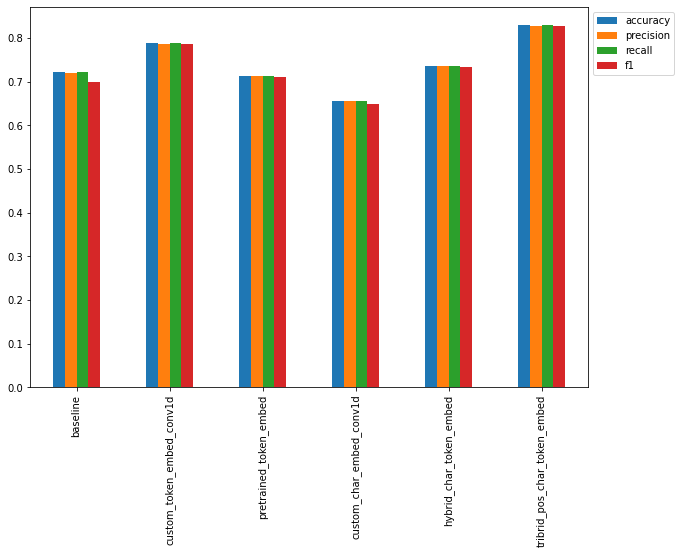

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

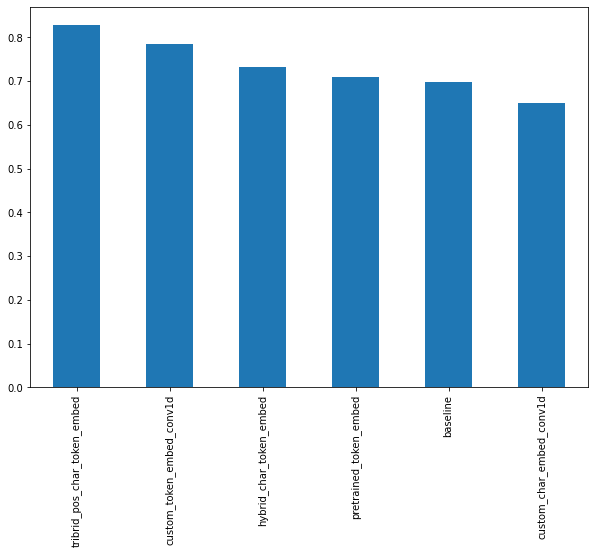

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Though, in comparison to the results reported in Table 3 of the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper, our model's F1-score is still underperforming (the authors model achieves an F1-score of 90.0 on the 20k RCT dataset versus our F1-score of ~82.6).

There are some things to note about this difference:

* Our models (with an exception for the baseline) have been trained on ~18,000 (10% of batches) samples of sequences and labels rather than the full ~180,000 in the 20k RCT dataset.
* This is often the case in machine learning experiments though, make sure training works on a smaller number of samples, then upscale when needed (an extension to this project will be training a model on the full dataset).
* Our model's prediction performance levels have been evaluated on the validation dataset not the test dataset (we'll evaluate our best model on the test dataset shortly).

## Save and load best performing model

In [ ]:
model_5.save("seq_sentence_classification")

INFO:tensorflow:Assets written to: seq_sentence_classification/assets


INFO:tensorflow:Assets written to: seq_sentence_classification/assets


In [ ]:
# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250 
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "/content/seq_sentence_classification"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path, 
                                          custom_objects={"TextVectorization": TextVectorization, # required for char vectorization
                                                          "KerasLayer": hub.KerasLayer}) # required for token embedding

## Make predictions and evalaute them against the truth labels

To make sure our model saved and loaded correctly, let's make predictions with it, evaluate them and then compare them to the prediction results we calculated earlier.

In [ ]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 195s 206ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 82.89090427644645,
 'f1': 0.8274837623900686,
 'precision': 0.8267206470093584,
 'recall': 0.8289090427644644}

In [ ]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([ True,  True,  True,  True])

In [ ]:
# Check loaded model summary (note the number of trainable parameters)
loaded_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, None)         0           char_inputs[0][0]                
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_embed (Embedding)          (None, None, 25)     1750        char_vectorizer[0][0]            
___________________________________________________________________________________________

## Evaluate model on test dataset
To make our model's performance more comparable with the results reported in Table 3 of the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper, let's make predictions on the test dataset and evaluate them.

In [ ]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [ ]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 194s 206ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 4, 0])>

In [ ]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.51534760245562,
 'f1': 0.8236409528987061,
 'precision': 0.8229208819695071,
 'recall': 0.8251534760245561}

It seems our best model (so far) still has some ways to go to match the performance of the results in the paper (their model gets 90.0 F1-score on the test dataset, where as ours gets ~82.1 F1-score).

However, as we discussed before our model has only been trained on 20,000 out of the total ~180,000 sequences in the RCT 20k dataset. We also haven't fine-tuned our pretrained embeddings (the paper fine-tunes GloVe embeddings). So there's a couple of extensions we could try to improve our results.

## Find most wrong


In [ ]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 14.1 s, sys: 1.98 s, total: 16.1 s
Wall time: 14.1 s


Now we'll enrich our test DataFame with a few values:

* A "prediction" (string) column containing our model's prediction for a given sample.
* A "pred_prob" (float) column containing the model's maximum prediction probabiliy for a given sample.
* A "correct" (bool) column to indicate whether or not the model's prediction matches the sample's target label.

In [ ]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.495620,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.344706,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.778582,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.636964,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.705798,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.878169,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.492315,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.449160,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.538297,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.537189,True


Sort DataFrame to find the samples with the highest "pred_prob" and where the prediction was wrong ("correct" == False)?

In [ ]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.937038,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.929456,False
13598,METHODS,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,9,RESULTS,0.927566,False
1221,RESULTS,data were collected prospectively for @ months...,3,13,METHODS,0.922907,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,0.913192,False
...,...,...,...,...,...,...,...
2098,BACKGROUND,these preliminary uncontrolled results need to...,2,15,METHODS,0.821777,False
15370,RESULTS,serum creatinine was assessed centrally at ser...,4,11,METHODS,0.820785,False
23202,RESULTS,the prebious trial has the potential to demons...,6,6,CONCLUSIONS,0.820623,False
9001,METHODS,p values less than @ were considered statistic...,7,14,RESULTS,0.820350,False


Visualize the above entries properly

In [ ]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.937038242816925, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9294557571411133, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: METHODS, Pred: RESULTS, Prob: 0.9275659918785095, Line number: 6, Total lines: 9

Text:
-@ % vs. fish : -@ % vs. fish + s : -@ % ; p < @ ) but there were no significant differences between groups .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9229071736335754, Line number: 3, Total lines: 13

Text:
data were collected prospectively for @ months beginning after completion of the first @ group clinic appointments ( @ months post randomization ) .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9131922721862793, Line number: 3, Total lines: 16

Text:
a cluster randomised trial was impleme

## Make example predictions


In [ ]:
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
import json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2021-09-30 15:27:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2021-09-30 15:27:28 (56.3 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'details': 'RCT of a manualized social treatment for high-functioning autism spectrum 

In [ ]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


First, we'll need to parse it using spaCy to turn it from a big chunk of text into sentences.



In [ ]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

spaCy has split the sentences in the abstract correctly.

Now our abstract has been split into sentences, how about we write some code to count line numbers as well as total lines.



In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'line_number': 0,
  'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'total_lines': 7},
 {'line_number': 1,
  'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'total_lines': 7},
 {'line_number': 2,
  'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'total_lines': 7},
 {'line_number': 3,
  'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'total_lines': 7},
 {'line_number': 4,
  'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'total_lines': 7},
 {'line_number': 5,
  'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'total_lines': 7},
 {'line_

In [ ]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

CPU times: user 957 ms, sys: 31.4 ms, total: 988 ms
Wall time: 949 ms


In [ ]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

In [ ]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


# Exercise :


#### 1. 
Train model_5 on all of the data in the training dataset for as many epochs until it stops improving. Since this might take a while, you might want to use:
* `tf.keras.callbacks.ModelCheckpoint` to save the model's best weights only.
* `tf.keras.callbacks.EarlyStopping` to stop the model from training once the validation loss has stopped improving for ~3 epochs.

In [ ]:
# Creating the callbacks 
check_filepath = 'best_weights/checkpoint.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= check_filepath , 
                                                               save_weights_only = True , 
                                                               save_best_only = True  , 
                                                               save_freq = 'epoch' , 
                                                               monitor = 'val_loss')

early_stopping  = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss' , 
                                                   patience = 3, min_delta = 0.5 , verbose = 1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, 
                                                 patience=2,
                                                 verbose=1, 
                                                 min_lr=1e-7)

In [ ]:
# Compiling the model and fitting it on the 100% of the data for 50 epochs! 

model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing= 0.2) ,
                    optimizer = tf.keras.optimizers.Adam() ,
                metrics = ['accuracy'])

history = model_5.fit(train_pos_char_token_dataset , 
                      epochs = 50 , 
                      validation_data = val_pos_char_token_dataset  , 
                      callbacks = [early_stopping , model_checkpoint_callback , 
                                   reduce_lr])

Epoch 1/50
5627/5627 [==============================] - 685s 121ms/step - loss: 0.9386 - accuracy: 0.8378 - val_loss: 0.9148 - val_accuracy: 0.8486
Epoch 2/50
5627/5627 [==============================] - 670s 119ms/step - loss: 0.9232 - accuracy: 0.8495 - val_loss: 0.9053 - val_accuracy: 0.8576
Epoch 3/50
5627/5627 [==============================] - 664s 118ms/step - loss: 0.9154 - accuracy: 0.8558 - val_loss: 0.9016 - val_accuracy: 0.8596
Epoch 4/50
5627/5627 [==============================] - 662s 118ms/step - loss: 0.9102 - accuracy: 0.8602 - val_loss: 0.8993 - val_accuracy: 0.8605
Epoch 00004: early stopping


In [ ]:
# Make predictions with token-char-positional hybrid model
model_5_fine_tune_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_fine_tune_pred_probs

945/945 [==============================] - 48s 50ms/step


array([[0.5953775 , 0.11590631, 0.0162613 , 0.2462109 , 0.02624407],
       [0.5754123 , 0.10156161, 0.05644777, 0.25694558, 0.00963277],
       [0.4484558 , 0.10420813, 0.01892557, 0.3932366 , 0.03517392],
       ...,
       [0.02323519, 0.08372433, 0.03025776, 0.02791356, 0.8348692 ],
       [0.02365711, 0.31402564, 0.07110781, 0.02688386, 0.5643256 ],
       [0.08357786, 0.8187845 , 0.05310585, 0.02421755, 0.0203142 ]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_5_fine_tune_preds = tf.argmax(model_5_fine_tune_pred_probs, axis=1)
model_5_fine_tune_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [ ]:
# Calculate results of token-char-positional hybrid model
model_5_fine_tune_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_fine_tune_preds)
model_5_fine_tune_results

{'accuracy': 86.04858996425261,
 'f1': 0.8572499735450112,
 'precision': 0.8621961119813023,
 'recall': 0.8604858996425262}

In [ ]:
compare_baseline_to_new_results(model_5_results, model_5_fine_tune_results)

Baseline accuracy: 82.93, New accuracy: 86.05, Difference: 3.12
Baseline precision: 0.83, New precision: 0.86, Difference: 0.03
Baseline recall: 0.83, New recall: 0.86, Difference: 0.03
Baseline f1: 0.83, New f1: 0.86, Difference: 0.03


So fine-tuning the the parameters does makes a difference in the models accuracy 

#### 2.

Checkout the Keras guide on using pretrained GloVe embeddings. Can you get this working with one of our models?
* Hint: You'll want to incorporate it with a custom token Embedding layer.
* It's up to you whether or not you fine-tune the GloVe embeddings or leave them frozen.

In [ ]:
# Loading the pre-trained embeddings 
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-09-30 16:36:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-09-30 16:36:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-09-30 16:36:02--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# Getting the path of the glove embedding (using 100D)
import numpy as np 
glove_path = 'glove.6B.100d.txt'

embedding_index = {}

# Making dict of vector representtion of the words (s --> [8, 48......])
with open(glove_path) as f:
  for line in f:
    
    # Getting the words and coef in a variable 
    word , coefs = line.split(maxsplit = 1)
    coefs = np.fromstring(coefs , 'f' , sep = ' ')
    
    # Adding the coefs to our embedding dict 
    embedding_index[word] = coefs

print(f'Found {len(embedding_index)} word vectors')

Found 400000 word vectors


Great we loaded in the data and the next step will be creating a corresponding embedding matrix. So we can fit our embedding_index to our Embedding layer.



In [ ]:
# Getting the vocabulary of the vectorizer 
text_vocab = text_vectorizer.get_vocabulary()
len(text_vocab)

64841

In [ ]:
# Getting the dict mapping word --> index 
word_index_text = dict(zip(text_vocab , range(len(text_vocab))))

In [ ]:
word_index_text

{'': 0,
 '[UNK]': 1,
 'the': 2,
 'and': 3,
 'of': 4,
 'in': 5,
 'to': 6,
 'with': 7,
 'a': 8,
 'were': 9,
 'was': 10,
 'for': 11,
 'patients': 12,
 'group': 13,
 'p': 14,
 'at': 15,
 'or': 16,
 'study': 17,
 'on': 18,
 'treatment': 19,
 'is': 20,
 'after': 21,
 'by': 22,
 'this': 23,
 'groups': 24,
 'as': 25,
 'an': 26,
 'from': 27,
 'that': 28,
 'randomized': 29,
 'between': 30,
 'not': 31,
 'trial': 32,
 'no': 33,
 'compared': 34,
 'control': 35,
 'be': 36,
 'significant': 37,
 'intervention': 38,
 'significantly': 39,
 'n': 40,
 'months': 41,
 'than': 42,
 'we': 43,
 'vs': 44,
 'rsb': 45,
 'lsb': 46,
 'clinical': 47,
 'placebo': 48,
 'baseline': 49,
 'ci': 50,
 'two': 51,
 'during': 52,
 'weeks': 53,
 'both': 54,
 'had': 55,
 'primary': 56,
 'mean': 57,
 'are': 58,
 'using': 59,
 'participants': 60,
 'there': 61,
 'all': 62,
 'time': 63,
 'years': 64,
 'pain': 65,
 'therapy': 66,
 'who': 67,
 'mg': 68,
 'more': 69,
 'effect': 70,
 'effects': 71,
 'but': 72,
 'risk': 73,
 'difference

In [ ]:
# Creating a function that will give us a embedding matrix 
def get_glove_embedding_matrix(num_tokens, embedding_dim, word_index):

  # Defining the hits and misses here 
  hits, misses = 0 , 0

  # Prepare the embedding matrix 
  embedding_matrix = np.zeros((num_tokens , embedding_dim ))
  for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector 
      hits += 1 
    else:
      misses += 1 

  return embedding_matrix , hits , misses

In [ ]:
# Using the above function to get the embedding matrix 

num_tokens_text = len(text_vocab) + 2 
embedding_dim = 100

sentence_embedding_matrix , hits_ , misses_ = get_glove_embedding_matrix(num_tokens_text , embedding_dim, word_index_text)
print(f'Hits: {hits_} and Misses: {misses_} for the sentence embedding matrix')

Hits: 29730 and Misses: 35111 for the sentence embedding matrix


In [ ]:
# Adding the embedding matrix to our Embedding layer (Sentence and characters)
from tensorflow.keras.layers import Embedding

sen_embedding_layer = Embedding(num_tokens_text , 
                            embedding_dim , 
                            embeddings_initializer = tf.keras.initializers.Constant(sentence_embedding_matrix) , 
                            trainable = False )

Before making the datasets, we gotta convert our string's into numerical values with the help of the vectorizer layers we have created for our both sentence and characters.

In [ ]:
# Creating the datasets for our both sentences and chars  

train_sen_vectors = text_vectorizer(np.array([[sen] for sen in train_sentences])).numpy()
val_sen_vectors = text_vectorizer(np.array([[sen] for sen in val_sentences])).numpy()

# Training and validation dataset 
train_ds = tf.data.Dataset.from_tensor_slices((train_sen_vectors , train_labels_encoded))
val_ds = tf.data.Dataset.from_tensor_slices((val_sen_vectors , val_labels_encoded))


# Applying the batch size and prefetching (performance optimization )
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)


train_ds,  val_ds

(<PrefetchDataset shapes: ((None, 55), (None,)), types: (tf.int64, tf.int64)>,
 <PrefetchDataset shapes: ((None, 55), (None,)), types: (tf.int64, tf.int64)>)

In [ ]:
train_sen_vectors[0].shape

(55,)

In [ ]:
# Sample 
input = layers.Input(shape = (None,) , dtype = 'int64')
glove_emb = sen_embedding_layer(input)
#sample_emb = embedding_layer(sample_tokens)
x = layers.Conv1D(128 , 5 , activation= 'relu' , padding = 'same')(glove_emb)
x = layers.MaxPooling1D(5, padding = 'same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.MaxPooling1D(5 , padding ='same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names) , activation= 'softmax')(x)

glove_model = tf.keras.Model(input , output)
glove_model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         6484300   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 128)         820

Now we gotta convert our list of string data to Numpy arrays of integer indicees.

In [ ]:
# Compiling and fitting the model
glove_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
                     optimizer = tf.keras.optimizers.Adam(), 
                     metrics = ['accuracy'])

glove_model.fit(train_ds,
                 epochs = 3 , 
                 validation_data = val_ds)

Epoch 1/3
5627/5627 [==============================] - 40s 7ms/step - loss: 0.6531 - accuracy: 0.7562 - val_loss: 0.5591 - val_accuracy: 0.7926
Epoch 2/3
5627/5627 [==============================] - 40s 7ms/step - loss: 0.5283 - accuracy: 0.8084 - val_loss: 0.5433 - val_accuracy: 0.8057
Epoch 3/3
5627/5627 [==============================] - 40s 7ms/step - loss: 0.4824 - accuracy: 0.8240 - val_loss: 0.5558 - val_accuracy: 0.8043


In [ ]:
# Make predictions with token-char-positional hybrid model
glove_model_preds_probs = glove_model.predict(val_ds, verbose=1)
glove_model_preds_probs

945/945 [==============================] - 3s 3ms/step


array([[3.7832627e-01, 3.9587614e-01, 3.7431931e-03, 1.4589605e-01,
        7.6158367e-02],
       [5.2480388e-01, 2.8460827e-01, 3.1907719e-03, 1.8012585e-01,
        7.2712763e-03],
       [5.1841241e-01, 8.8748540e-04, 3.7571811e-03, 4.7677627e-01,
        1.6668439e-04],
       ...,
       [2.0338436e-13, 1.3639185e-07, 2.3391522e-07, 1.3488780e-13,
        9.9999964e-01],
       [4.7313017e-05, 2.8345004e-01, 1.6095718e-04, 3.7082798e-05,
        7.1630466e-01],
       [5.7578778e-05, 9.9990201e-01, 4.6541146e-07, 1.4249539e-06,
        3.8540133e-05]], dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
glove_model_preds = tf.argmax(glove_model_preds_probs, axis=1)
glove_model_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 0, ..., 4, 4, 1])>

In [ ]:
# Calculate results of token-char-positional hybrid model
glove_model_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=glove_model_preds)
glove_model_results

{'accuracy': 80.43161657619488,
 'f1': 0.8012390002840082,
 'precision': 0.8096151806033068,
 'recall': 0.8043161657619489}